## Deep Learning for Fashion-MNIST Clothing Classification (PyTorch)

### Parameter Initialization

While training a network, we need to set the weights to values that minimize the convergence between model's output and the training data. And the initial value of the weights plays a significant role here.

The initialization step can be critical to the model’s ultimate performance, and it requires the right method.
- **Case 0:** Initializing all the weights with `zeros` leads the neurons to learn the same features during training. In fact, any constant initialization scheme will perform very poorly.
- **Case 1:** A `too-large` initialization leads to exploding gradients.
- **Case 2:** A `too-small` initialization leads to vanishing gradients.

To prevent the gradients of the network’s activations from vanishing or exploding, we will stick to the following rules of thumb:

- The `mean` of the activations should be `zero`.
- The `variance` of the activations should stay the `same across every layer`.

**I will try to train the model with `ADAM`, `SGD`, and `RMSProp` optimizers with `normal` and `xavier` ininitialization.**

#### Import the needed functions

In [42]:
import torch 
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline
np.random.seed(1)

#### About the data
- 28x28 images
- 10 classes
- Single color channel (Black&White)
- Centered objects
- 50000 training set members
- 10000 test set members

**Create `Fashion class` to download and save the data**

In [2]:
# Fashion Class that enables the Dataset download and basic transformations
class Fashion(datasets.FashionMNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.urls = [
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
        ]
        super(Fashion, self).__init__(
            root, train=train, transform=transform, target_transform=target_transform, download=download
        ) 

**Download the `train/test` data**

In [3]:
# Downloading the data
train_data = Fashion('Torch Data/Torch Fashion', train=True, download=True,
                     transform=transforms.Compose([transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))]))

test_data = Fashion('Torch Data/Torch Fashion', train=False, download=True,
                     transform=transforms.Compose([transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))]))

**Create `decode_label` function to interpret the model classes**

In [4]:
# return class name
def decode_label(l):
    return train_data.classes[l]

**Create `DataLoader` for the training Pipeline**

In [5]:
# Create a data loader for train and test data set
# Split the train data loader for train/validation
train_size = train_data.data.shape[0]
val_size, train_size = int(0.20 * train_size), int(0.80 * train_size) # 80 / 20 train-val split
test_size = test_data.data.shape[0]
batch_size = 100

# Add dataset to dataloader that handles batching
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=SubsetRandomSampler(np.arange(val_size, val_size+train_size)))
val_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=SubsetRandomSampler(np.arange(0, val_size)))
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Show random samples of the data

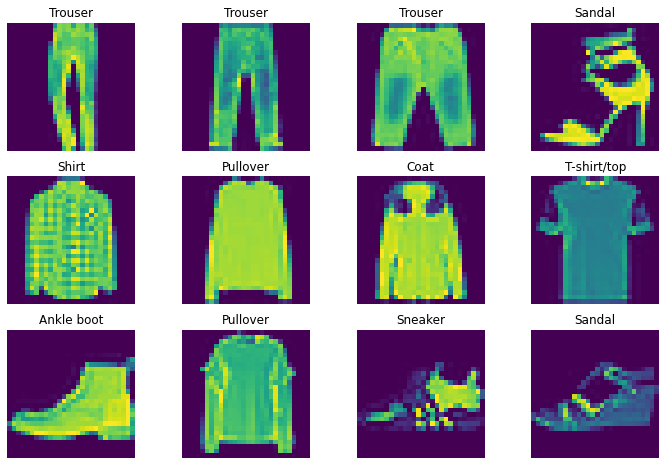

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i in range(12):
    idx = np.random.randint(train_data.data.shape[0], size=1)[0]
    r, c = i // 4, i % 4
    img = train_data.data[idx]
    label = decode_label(train_data.targets[idx])
    axes[r][c].set_title(label)
    axes[r][c].axis('off')
    axes[r][c].imshow(img.numpy())
    
plt.draw()

### `NN Model`

**`HyperParameters initializer`**

In [33]:
# Parameter class
class Parameters:
    def __init__(self):
        self.input_shape = 28*28
        self.hiddens = [64, 32]
        self.num_classes = 10
        self.n_epochs = 10
        self.lr = 0.01
        self.batch_size = 100
        self.train_val = 0.8 # 80 / 20 train-val split
        self.val_size = val_size
        self.train_size = train_size
        self.test_size = test_size

P = Parameters()

In [34]:
class NNFashionMNIST(nn.Module):
    def __init__(self, P):
        super(NNFashionMNIST, self).__init__()
        self.linear1 = nn.Linear(P.input_shape, P.hiddens[0])
        self.linear2 = nn.Linear(P.hiddens[0], P.hiddens[1])
        self.linear3 = nn.Linear(P.hiddens[1], P.num_classes)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        out = self.relu(self.linear1(x))
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        out = self.log_softmax(out)
        return out
    
print(NNFashionMNIST(P))

NNFashionMNIST(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (log_softmax): LogSoftmax(dim=1)
)


**`Weight initializer`**

In [35]:
# parameter initializer
def xavier_init(layer):
    if type(layer) == nn.Linear:
        feature_in = layer.weight.size(1)
        feature_out = layer.weight.size(0)
        std = np.sqrt(2.0 / (feature_in+feature_out))
        layer.weight.data.normal_(0, std)
        
# initialize the parameters using "normal" distribution
def normal_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

**`model inference`**

In [36]:
# define a model inference
def inference(model, loader, P=P):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in loader:
            images = Variable(data.view(P.batch_size, -1)).to(device)
            labels = Variable(labels).to(device)
            output = model(images)
            _,predictions = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
        return correct / total

**`Model Trainer`**

In [43]:
# define the criterion
criterion = nn.CrossEntropyLoss()

# Trainer Class
class Trainer:
    
    def __init__(self, model, optimizer, criterion, load_path=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        
        # if model exist
        if load_path:
            self.model = torch.load(load_path)
        
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        
    def run(self, train_loader, val_loader, P=P):
        ## Setup Metric class
        Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])
#         print("Start Training...")
        self.metrics = []
        self.model.train() 
        for epoch in range(P.n_epochs):
            epoch_loss = 0.0
            correct = 0
            data_iter = enumerate(train_loader)
            prog_bar = tqdm(range(len(train_loader)))
            for step in prog_bar: # iter over batches
                batch_idx, (data, labels) = next(data_iter)
                # Clear the gradients
                self.optimizer.zero_grad()
                # Get X, y
                images = Variable(data.view(P.batch_size, -1)).to(device)
                labels = Variable(labels).to(device)  
                # Forward Pass
                out = self.model(images)
                _, pred = torch.max(out.data, 1)
                correct += pred.eq(labels.view_as(pred)).sum()
                # Calculate the Loss
                loss = self.criterion(out, labels)
#                 loss = F.nll_loss(out, labels)
                # Calculate the total Loss
                epoch_loss += loss.item()
                # Calculate gradients
                loss.backward()
                # Update Weights
                self.optimizer.step()
                #Check point
                prog_bar.set_description('{}: Epoch {}/{}, Loss: {:.4f}' 
                                         .format(type(self.optimizer).__name__.upper(), epoch+1, P.n_epochs, loss.item()))
            total_loss = epoch_loss/P.train_size
            train_error = 1.0 - correct/P.train_size  # 1 - acc
            val_error = 1.0 - inference(self.model, val_loader)  # 1 - acc
#             print("epoch: {0}, loss: {1:.8f}".format(epoch+1, total_loss))
            self.metrics.append(Metric(loss=total_loss, 
                                       train_error=train_error,
                                       val_error=val_error))


**Lets try many initializers and optimizers**

### 1) Normal initialization

In [44]:
print("Normal INIT WEIGHTS")

#==>ADAM OPtimizer
# create model instance
normal_model = NNFashionMNIST(P)
normal_model.apply(normal_init)

AdamOptimizer = torch.optim.Adam(normal_model.parameters(), lr=P.lr)
normal_Adam_trainer = Trainer(normal_model, AdamOptimizer, criterion, '')
normal_Adam_trainer.run(train_loader, val_loader)
normal_Adam_trainer.save_model('./Models/normal_model_ADAM.pt')
print('')

#==>SGD OPtimizer
normal_model = NNFashionMNIST(P)
normal_model.apply(normal_init)

SGDOptimizer = torch.optim.SGD(normal_model.parameters(), lr=P.lr)
normal_SGD_trainer = Trainer(normal_model, SGDOptimizer, criterion, '')
normal_SGD_trainer.run(train_loader, val_loader)
normal_SGD_trainer.save_model('./Models/normal_model_SGD.pt')
print('')

#==>RMSPROP OPtimizer
normal_model = NNFashionMNIST(P)
normal_model.apply(normal_init)

RMSpropOptimizer = torch.optim.RMSprop(normal_model.parameters(), lr=P.lr)
normal_RMSprop_trainer = Trainer(normal_model, RMSpropOptimizer, criterion, '')
normal_RMSprop_trainer.run(train_loader, val_loader)
normal_RMSprop_trainer.save_model('./Models/normal_model_RMSprop.pt')
print('')

Normal INIT WEIGHTS


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

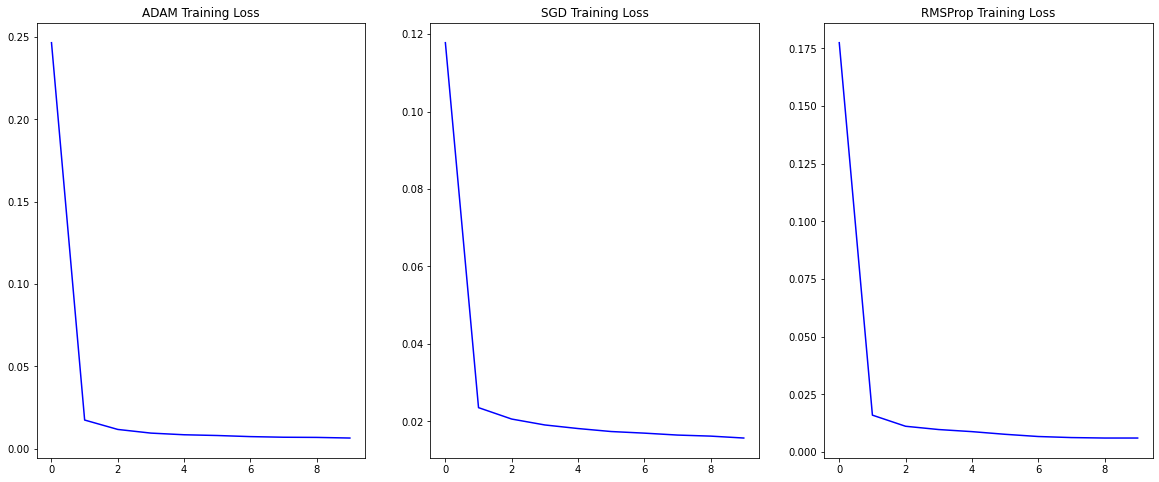

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
m = [normal_Adam_trainer.metrics, normal_SGD_trainer.metrics, normal_RMSprop_trainer.metrics]

for i, (metrics, opt) in enumerate(zip(m, ['ADAM','SGD','RMSProp'])):
    axes[i].plot([metric.loss for metric in metrics], 'b')
    axes[i].set_title(f'{opt} Training Loss')

#### Models test using train data

In [46]:
model = NNFashionMNIST(P)
model.load_state_dict(torch.load('./Models/normal_model_ADAM.pt'))
test_acc = inference(model, test_loader)
print("Test accuracy of model optimizer with Adam: {0:.2f} %".format(test_acc * 100))

model = NNFashionMNIST(P)
model.load_state_dict(torch.load('./Models/normal_model_SGD.pt'))
test_acc = inference(model, test_loader)
print("Test accuracy of model optimizer with SGD: {0:.2f} %".format(test_acc * 100))

model = NNFashionMNIST(P)
model.load_state_dict(torch.load('./Models/normal_model_RMSprop.pt'))
test_acc = inference(model, test_loader)
print("Test accuracy of model optimizer with RMSProp: {0:.2f} %".format(test_acc * 100))

Test accuracy of model optimizer with Adam: 76.00 %
Test accuracy of model optimizer with SGD: 42.50 %
Test accuracy of model optimizer with RMSProp: 75.79 %


> #### Of course ADAM Optimizer is the best !!

### 2) Xavier initializer

In [47]:
print("XAVIER INIT WEIGHTS")

print("==>ADAM OPtimizer")
# create model instance
xavier_Adam_model = NNFashionMNIST(P)
xavier_Adam_model.apply(xavier_init)

AdamOptimizer = torch.optim.Adam(xavier_Adam_model.parameters(), lr=P.lr)
xavier_Adam_trainer = Trainer(xavier_Adam_model, AdamOptimizer, criterion, '')
xavier_Adam_trainer.run(train_loader, val_loader)
xavier_Adam_trainer.save_model('./models/xavier_model_ADAM.pt')
print('')


print("==>SGD OPtimizer")
xavier_SGD_model = NNFashionMNIST(P)
xavier_SGD_model.apply(xavier_init)

SGDOptimizer = torch.optim.SGD(xavier_SGD_model.parameters(), lr=P.lr)
xavier_SGD_trainer = Trainer(xavier_SGD_model, SGDOptimizer, criterion, '')
xavier_SGD_trainer.run(train_loader, val_loader)
xavier_SGD_trainer.save_model('./models/xavier_model_SGD.pt')
print('')

print("==>RMSPROP OPtimizer")
xavier_RMSprop_model = NNFashionMNIST(P)
xavier_RMSprop_model.apply(xavier_init)

RMSpropOptimizer = torch.optim.RMSprop(xavier_RMSprop_model.parameters(), lr=P.lr)
xavier_RMSprop_trainer = Trainer(xavier_RMSprop_model, RMSpropOptimizer, criterion, '')
xavier_RMSprop_trainer.run(train_loader, val_loader)
xavier_RMSprop_trainer.save_model('./Models/xavier_model_RMSprop.pt')
print('')

XAVIER INIT WEIGHTS
==>ADAM OPtimizer


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]


==>SGD OPtimizer


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]


==>RMSPROP OPtimizer


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

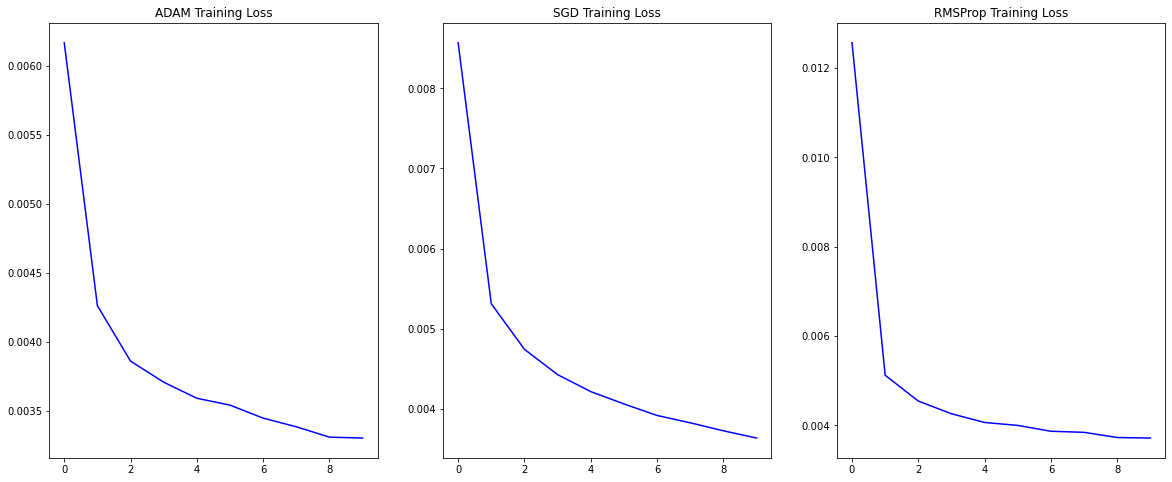

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
m = [xavier_Adam_trainer.metrics, xavier_SGD_trainer.metrics, xavier_RMSprop_trainer.metrics]

for i, (metrics, opt) in enumerate(zip(m, ['ADAM','SGD','RMSProp'])):
    axes[i].plot([metric.loss for metric in metrics], 'b')
    axes[i].set_title(f'{opt} Training Loss')

> ### So, the model converges faster when initializing the weights using xavier initializer.

In [49]:
model = NNFashionMNIST(P)
model.load_state_dict(torch.load('./Models/xavier_model_ADAM.pt'))
test_acc = inference(model, test_loader)
print("Test accuracy of model optimizer with Adam: {0:.2f} %".format(test_acc * 100))

model = NNFashionMNIST(P)
model.load_state_dict(torch.load('./Models/xavier_model_SGD.pt'))
test_acc = inference(model, test_loader)
print("Test accuracy of model optimizer with SGD: {0:.2f} %".format(test_acc * 100))

model = NNFashionMNIST(P)
model.load_state_dict(torch.load('./Models/xavier_model_RMSprop.pt'))
test_acc = inference(model, test_loader)
print("Test accuracy of model optimizer with RMSProp: {0:.2f} %".format(test_acc * 100))

Test accuracy of model optimizer with Adam: 85.33 %
Test accuracy of model optimizer with SGD: 84.64 %
Test accuracy of model optimizer with RMSProp: 85.75 %


### Lets enhance the model's performance using CNN architecture

### `CNN Model`

**`Weight initializer`**

In [50]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.xavier_normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)

**`Swish Activation Function`**

In [51]:
class Swish(nn.Module):
    def forward(self, input):
        return (input * torch.sigmoid(input))
    
    def __repr__(self):
        return self.__class__.__name__ + ' ()'

**`HyperParameters initilizer`**

In [52]:
# Parameter class
class Parameters:
    def __init__(self):
        self.input_shape = (1, 28, 28)
        self.hiddens_filters = [16, 32, 64]
        self.num_classes = 10
        self.n_epochs = 5
        self.lr = 0.015
        self.batch_size = 100
        self.train_val = 0.8 # 80 / 20 train-val split
        self.val_size = val_size
        self.train_size = train_size
        self.test_size = test_size
        
P = Parameters()

In [95]:
class CNNFashionMNIST(nn.Module):
    
    def __init__(self, P):
        super(CNNFashionMNIST, self).__init__()
        self.ch, self.h, self.w = P.input_shape
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.ch, 
                      out_channels=P.hiddens_filters[0],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(P.hiddens_filters[0]),
            Swish(),
            nn.MaxPool2d(kernel_size=2, stride=1)
            
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=P.hiddens_filters[0], 
                      out_channels=P.hiddens_filters[1],
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(P.hiddens_filters[1]),
            Swish(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=P.hiddens_filters[1], 
#                       out_channels=P.hiddens_filters[2],
#                       kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(P.hiddens_filters[2]),
#             Swish(),
#             nn.MaxPool2d(kernel_size=2, stride=1)
#         )
        
        flatten_shape = self._get_conv_output((self.ch, self.h, self.w))
        self.fc1 = nn.Linear(flatten_shape, P.num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
#         x = self.layer3(x)
        return x
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
#         out = self.drpout(out)
#         out = self.fc2(out)
#         out = self.drpout(out)
        out = self.softmax(out)
        return out
    
print(CNNFashionMNIST(P))

CNNFashionMNIST(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish ()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish ()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=21632, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [54]:
# define a model inference
def inference(model, loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in loader:
            images = Variable(data).to(device)
            labels = Variable(labels).to(device)
            output = model(images)
            _,predictions = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
        return correct / total

**`Model Trainer`**

In [91]:
## Setup Metric class
Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])
min_valid_loss = np.inf

# Trainer Class
class Trainer:
    
    def __init__(self, model, optimizer, criterion, scheduler=None, load_path=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        tqdm.refresh
        # if model exist
        if load_path:
            self.model = torch.load(load_path)
        
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        
    def run(self, train_loader, val_loader, P=P):
        min_valid_loss = np.inf
        ## Setup Metric class
        Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])
#         print("Start Training...")
        self.metrics = []
        self.model.train() 
        for epoch in range(P.n_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            data_iter = enumerate(train_loader)
            t_prog_bar = tqdm(range(len(train_loader)))
            lr = self.scheduler.get_last_lr()[0]
            for step in t_prog_bar: # iter over batches
                
                # get the input images and their corresponding labels
                batch_idx, (data, labels) = next(data_iter)
                # clear the gradient
                self.optimizer.zero_grad()
                # wrap them in a torch Variable and move tnsors to the configured device
                images, labels = Variable(data).to(device), Variable(labels).to(device)                                  
                # Forward Pass
                target = self.model(data)
                # get the predicted class from the maximum value in the output-list of class scores
                pred = target.data.max(1, keepdim=True)[1]
                predicted = pred.eq(labels.data.view_as(pred))
                # Count the correct
                correct += predicted.sum()
                # Find the Loss
                loss = self.criterion(target, labels)
#                 loss = F.nll_loss(target, labels)
                # Backward Pass
                # Calculate gradients
                loss.backward()
                # Update Weights
                self.optimizer.step()
                # Calculate total Loss
                epoch_loss += loss.item()
                # Calculate total samples
                total += labels.size(0)
                
                t_prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}, lr={:.7f}'.format(epoch+1,P.n_epochs,loss.item(),lr))

            valid_loss = 0.0
#             v_prog_bar = tqdm(range(len(val_loader)))
            model.eval() # Optional when not using Model Specific layer
            for data, labels in val_loader:
                # Forward Pass
                target = model(data)
                # Find the Loss
                loss = self.criterion(target,labels)
#                 loss = F.nll_loss(target,labels)
                # Calculate Loss
                valid_loss += loss.item()
        
                t_prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}, Val_Loss: {:.4f}, lr={:.7f}'\
                                         .format(epoch+1, P.n_epochs, loss.item(), valid_loss, lr))

            #Check point
            if min_valid_loss > valid_loss:
                print('Validation Loss Decreased ({:.6f} ===> {:.6f}) \nSaving The Model'.format(min_valid_loss/len(val_loader), 
                                                                                               valid_loss/len(val_loader)))

                min_valid_loss = valid_loss/len(val_loader)

            total_loss = epoch_loss/P.train_size
            train_error = 1.0 - correct/P.train_size  # 1 - acc
            val_error = 1.0 - inference(self.model, val_loader)  # 1 - acc
            
            self.metrics.append(Metric(loss=epoch_loss, 
                                       train_error=train_error,
                                       val_error=val_error))
            
            # Decrease the lr
            scheduler.step()

In [93]:
# define the model
model = CNNFashionMNIST(P)
# define the criterion
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr=P.lr)
# define the scheduler (learninig rate decaying)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
# start training
model_trainer = Trainer(model, optimizer, criterion, scheduler, '')
model_trainer.run(train_loader, val_loader)

  0%|          | 0/480 [00:00<?, ?it/s]

Validation Loss Decreased (inf ===> 0.727003) 
 Saving The Model


  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

In [98]:
# save the model
model.save_model('./Models/cnn_model.pt')

# test the model on the data test
model = CNNFashionMNIST(P)
model.load_state_dict(torch.load('./Models/cnn_model.pt'))
test_acc = inference(model, test_loader)

print("Test accuracy of CNN model is : {0:.2f} %".format(test_acc * 100))

Test accuracy of CNN model is : 88.85 %


> ### It's better !

### Lets visualize model's output

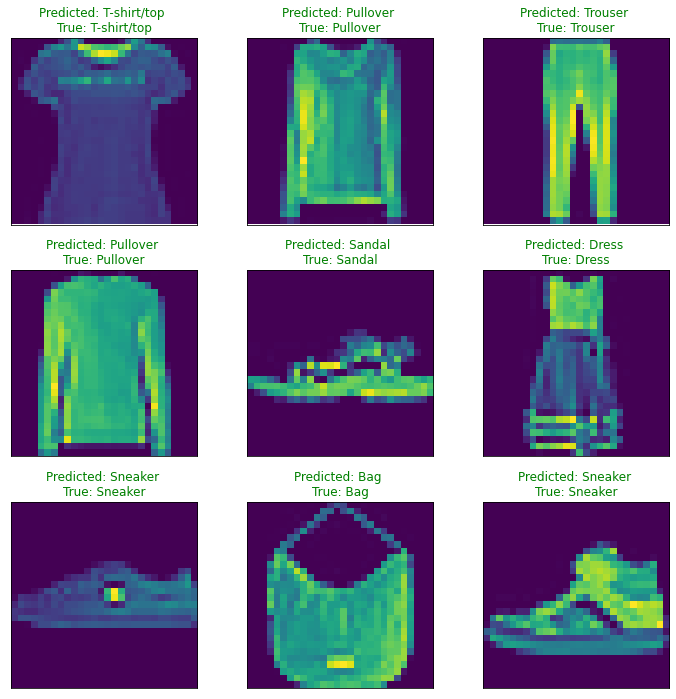

In [104]:
data = enumerate(test_loader)
# Show Sample Predictions
fig = plt.figure(figsize=(10,10))
for i in range(9):
    _, (images, labels) = next(data)
    idx = np.random.randint(0, P.batch_size, 1)
    model.eval()
    prediction = model(images[idx])
    pred = decode_label(prediction.data.max(1, keepdim=True)[1].item())
    act = decode_label(labels[idx])
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(np.squeeze(images[idx]), cmap='viridis', interpolation='nearest')
    plt.title("Predicted: {} \nTrue: {}".format(pred, act),color=("green" if pred==act else "red"))
    plt.xticks([])
    plt.yticks([])